In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import Counter
import GraphRicciCurvature
%matplotlib inline

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

from GraphRicciCurvature.OllivierRicci import OllivierRicci

Загрузка данных.

In [2]:
file_path = "/Users/natalabereberdina/dip/arxiv_embeddings_10000.csv"
df = pd.read_csv(file_path)

x_train = np.array([np.fromstring(emb[1:-1], sep=",") for emb in df["embedding"]])
y_train = df["categories"]

In [3]:
print(type(x_train[0]), len(x_train), len(x_train[0]))

X = np.zeros((len(x_train), len(x_train[0])))
for i in range(len(x_train)):
    X[i] = np.array(x_train[i])
df = pd.DataFrame(X)
df["label"] = pd.DataFrame(y_train)

<class 'numpy.ndarray'> 10000 1536


Вспомогательные функции.

In [4]:
from visual_and_stats_func import two_counts_gist, two_visualisation_target_colors, show_results, graph_main_info
from dist_func import calculate_and_save_distances, build_investments_dist
from surgery import simple_surgery, another_surgery
from build_graph_func import (
    find_treshhold,
    get_random_sample,
    remove_degree_zero_nodes_efficient,
    table_by_graph,
    get_indices,
    get_indices_from_top_label,
)

Начало эксперимента.

In [27]:
indices = get_indices_from_top_label(x_train, y_train, 5)

Распределение классов в выборке: Counter({'cs.AI': 30, 'cs.CV': 30, 'cs.LG stat.ML': 24, 'cs.LG': 10, 'cs.CL': 6})


In [6]:
calculate_and_save_distances(x_train, indices, filename="mnist_dist_sample.csv", metric="mse")
threshold = find_treshhold("mnist_dist_sample.csv", indices, rule="avg")
(x_test, y_test, graph_MNIST) = get_random_sample("mnist_dist_sample.csv", x_train, y_train, indices, threshold)

threshold =  0.00030276730229879706


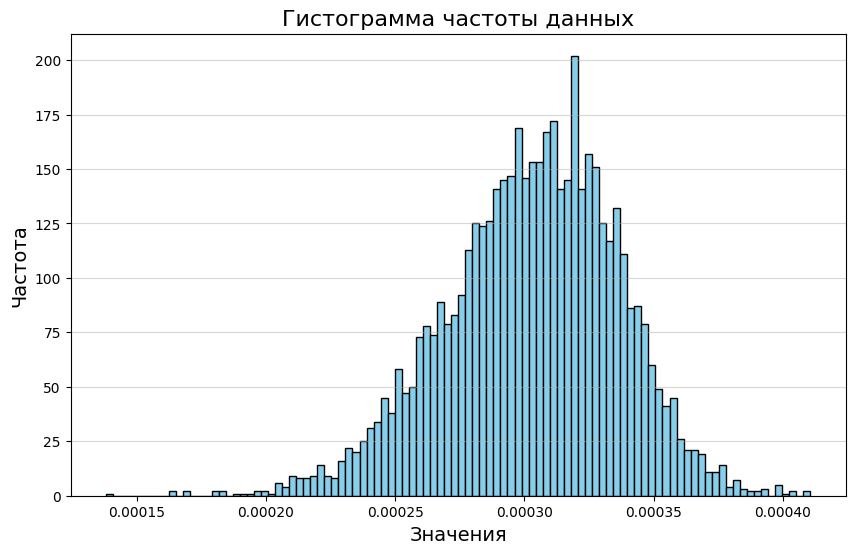

In [7]:
build_investments_dist(filename="mnist_dist_sample.csv", indices=indices)

In [8]:
graph_main_info(graph_MNIST)

counts = Counter(y_test)
sorted_counts = [counts[key] for key in sorted(counts.keys())]
print(sorted_counts)

Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1
[30, 6, 30, 10, 24]


Удаляем вершины нулевой степени.

In [9]:
graph_MNIST = remove_degree_zero_nodes_efficient(graph_MNIST)
df_graph = table_by_graph(df, graph_MNIST)[1]

graph_main_info(graph_MNIST)
counts_non_zero = Counter(df_graph["label"])
sorted_counts_non_zero = [counts_non_zero[key] for key in sorted(counts_non_zero.keys())]
print(sorted_counts_non_zero)

Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1
[30, 6, 30, 10, 24]


In [10]:
graph_MNIST.nodes

NodeView(('[0.004874754697084427, 0.012842132709920406, 0.005925842560827732, -0.02076571434736252, -0.022409724071621895, 0.0006527185905724764, -0.012653475627303123, -0.004595138598233461, -0.00421782536432147, -0.04616699367761612, 0.0352788083255291, 0.02870277315378189, 0.01774720661342144, 0.012276162393391132, 0.006293049082159996, -0.011299190111458302, 0.023056546226143837, 0.029457399621605873, -0.011319403536617756, -0.004089808091521263, -0.02083309181034565, -0.0014940937981009483, -0.026681451126933098, -0.020240170881152153, -0.0034244563430547714, 0.007579957600682974, 0.021439488977193832, -0.038485970348119736, -0.010288529098033905, -0.012303113006055355, 0.019135180860757828, 0.021169979125261307, -0.03686891496181488, 0.01804366707801819, 0.00623240927234292, 0.0019371001981198788, 0.009453048929572105, -0.015308145433664322, 0.021223880350589752, -0.022342346608638763, 0.02899923361837864, 0.033446140587329865, 0.0058685713447630405, -0.014162729494273663, 0.0254

Вычисляем кривизну Риччи и поток Риччи.

TRACE:Number of nodes: 100
TRACE:Number of edges: 2349
TRACE:Start to compute all pair shortest path.
TRACE:0.006384 secs for all pair by NetworKit.
INFO:0.352468 secs for Ricci curvature computation.


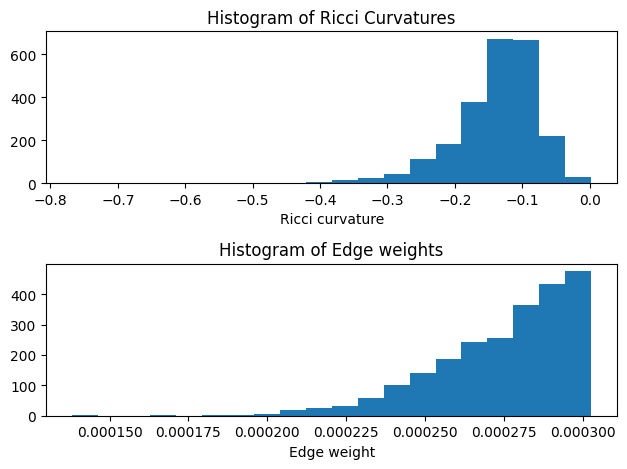

In [11]:
orc = OllivierRicci(graph_MNIST, alpha=0.5, method="ATD", verbose="TRACE")
orc.compute_ricci_curvature()
G = orc.G.copy()
show_results(G)

Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1


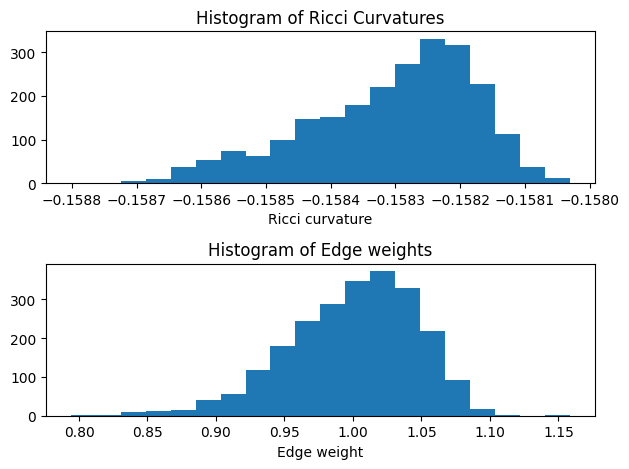

In [12]:
orc.set_verbose("ERROR")
orc.compute_ricci_flow(iterations=10)
G_rf = orc.G.copy()
show_results(G_rf)
graph_main_info(G_rf)

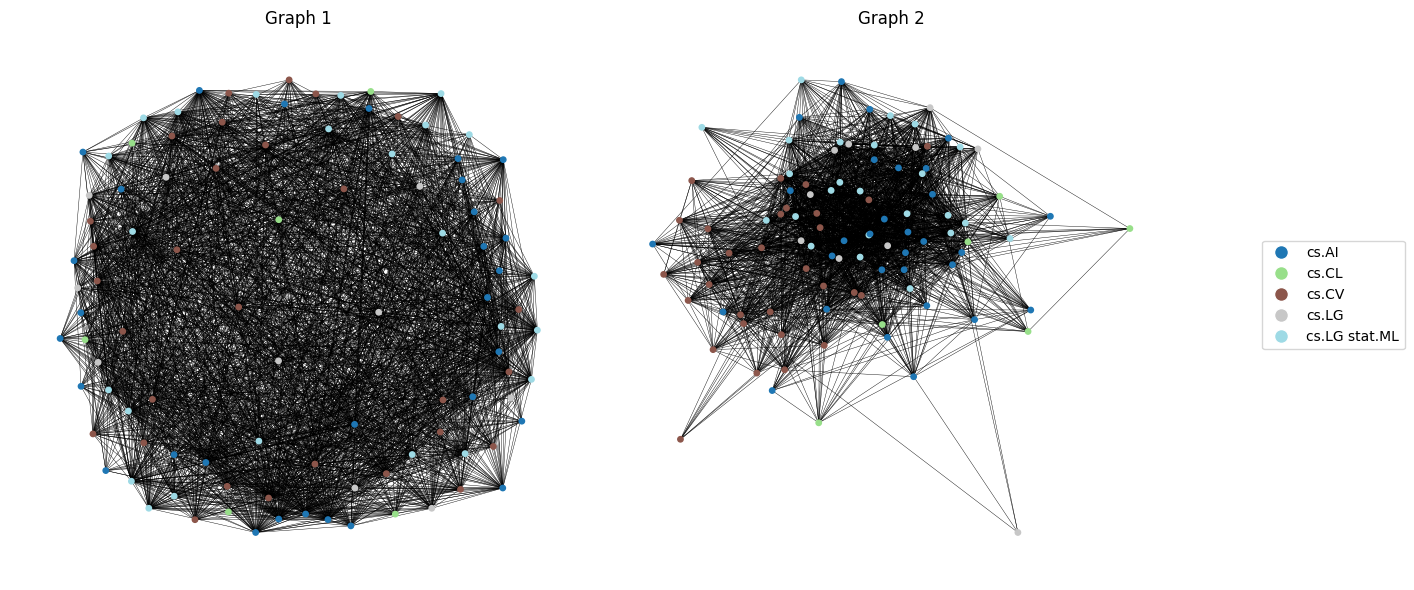

In [13]:
two_visualisation_target_colors(G, G_rf, iteration_spring=10, legend=True)

После подсчета Риччи флоу мы удаляем ребра с большим весом с помощью simple_surgery.

another_surgery - моя функция, которая наоборот удаляет ребра с маленьким весом.

In [14]:
orc.set_verbose("ERROR")
orc.compute_ricci_flow(iterations=1)
G_rf = orc.G.copy()

In [15]:
G_after_mcs = simple_surgery(G_rf, cut=1.02)
G_after_as = another_surgery(G_rf, cut=1.02)

Сравниваем графы после simple_surgery и another_surgery

In [16]:
graph_main_info(G_after_mcs)

Количество вершин в графе: 100
Количество ребер в графе: 1454
Количество компонент связности: 2


In [17]:
graph_main_info(G_after_as)

Количество вершин в графе: 100
Количество ребер в графе: 895
Количество компонент связности: 8


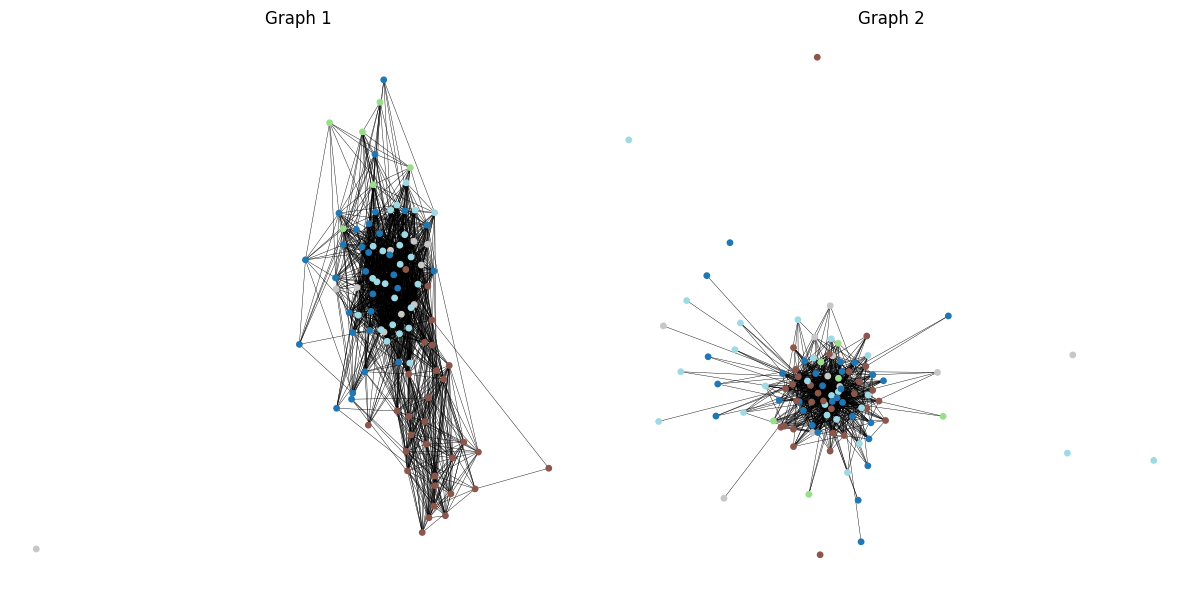

In [18]:
two_visualisation_target_colors(G_after_mcs, G_after_as, iteration_spring=10)

Визуализации с разным параметром cut.

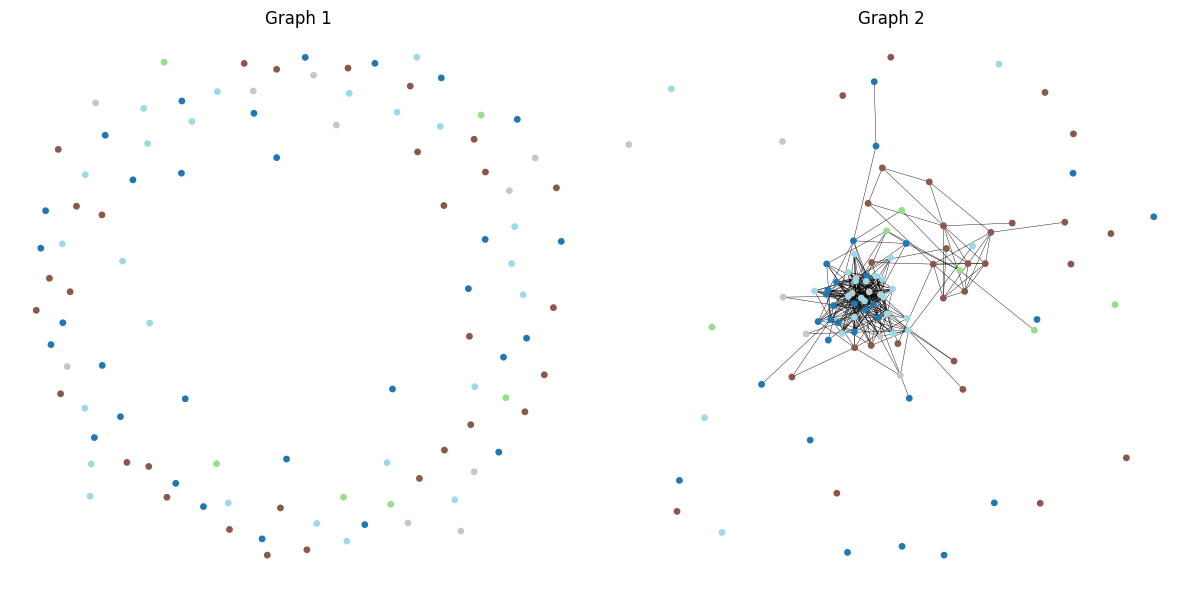

In [19]:
G_after_mcs_2 = simple_surgery(G_rf, cut=0.7)
G_after_mcs_5 = simple_surgery(G_rf, cut=0.95)
two_visualisation_target_colors(G_after_mcs_2, G_after_mcs_5, iteration_spring=10)

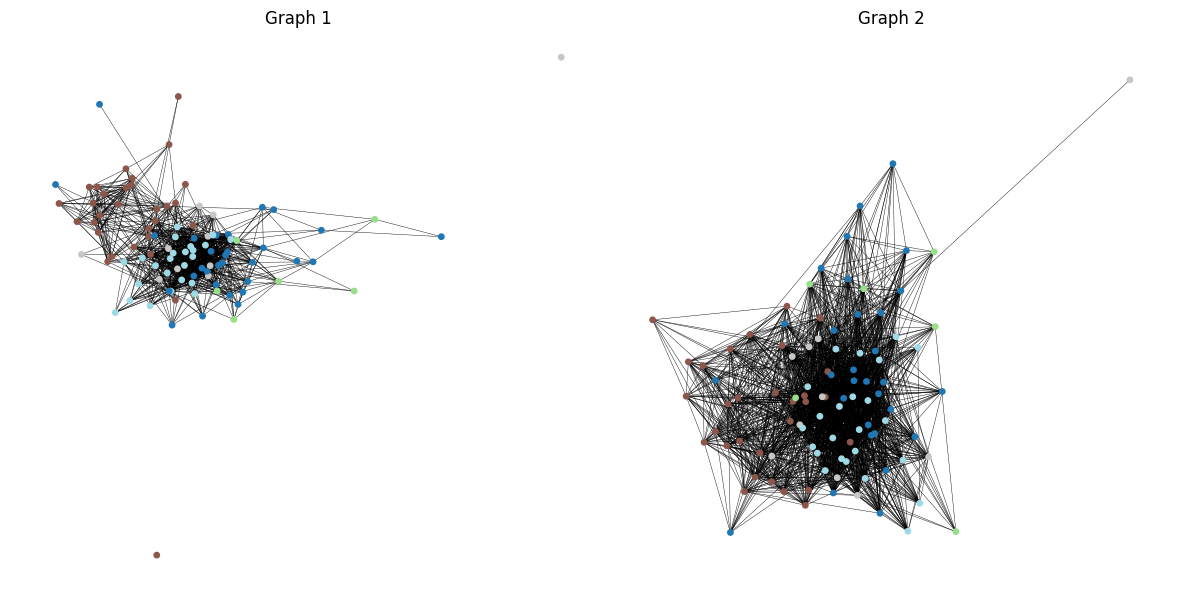

In [20]:
G_after_mcs_2 = simple_surgery(G_rf, cut=1.0)
G_after_mcs_5 = simple_surgery(G_rf, cut=1.05)
two_visualisation_target_colors(G_after_mcs_2, G_after_mcs_5, iteration_spring=10)

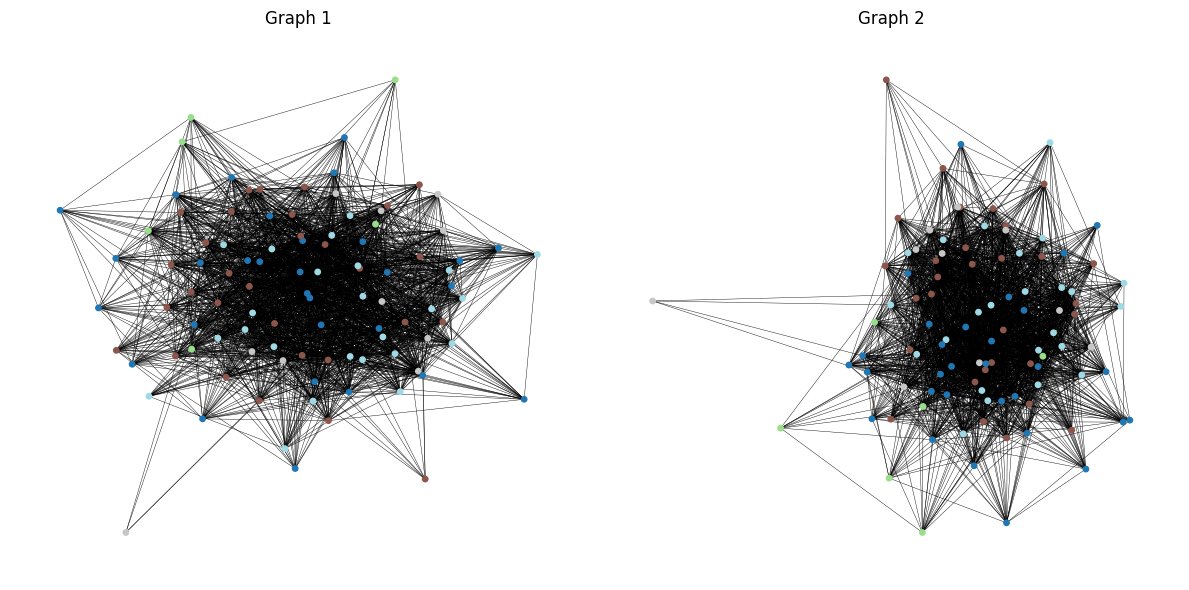

In [21]:
G_after_mcs_2 = simple_surgery(G_rf, cut=1.5)
G_after_mcs_5 = simple_surgery(G_rf, cut=2.0)
two_visualisation_target_colors(G_after_mcs_2, G_after_mcs_5, iteration_spring=10)

In [22]:
graph_mcs_nz = remove_degree_zero_nodes_efficient(G_after_mcs)
df_graph_mcs_nz = table_by_graph(df, graph_mcs_nz)[1]

graph_main_info(graph_mcs_nz)

counts_mcs_nz = Counter(df_graph_mcs_nz["label"])
sorted_counts_non_zero = [counts_mcs_nz[key] for key in sorted(counts_mcs_nz.keys())]
print(sorted_counts_non_zero)

Количество вершин в графе: 99
Количество ребер в графе: 1454
Количество компонент связности: 1
[30, 6, 30, 9, 24]


Алгоритм итеративной кластеризации. 

In [46]:
import matplotlib.pyplot as plt
import networkx as nx
from GraphRicciCurvature.OllivierRicci import OllivierRicci


def my_cluster_iterative_surgery(
    G_origin: nx.Graph, weight: str = "weight", surgery_iter: int = 12, ricci_iter: int = 10, threshold: float = None
) -> nx.Graph:
    """Performs iterative graph surgery with fixed label colors and large legend.

    Args:
        G_origin: Input graph to process
        weight: Edge weight attribute name
        surgery_iter: Number of surgery iterations
        ricci_iter: Number of Ricci flow iterations per surgery step
        threshold: Initial cutting threshold (None for auto calculation)

    Returns:
        Processed graph after iterative surgery
    """
    G = G_origin.copy()
    orc = OllivierRicci(G, alpha=0.5, method="ATD", verbose="TRACE")
    orc.compute_ricci_curvature()
    G = orc.G.copy()

    all_labels = set(nx.get_node_attributes(G, "label").values())
    label_to_color = {label: i for i, label in enumerate(sorted(all_labels))}

    fig = plt.figure(figsize=(28, 12))
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.7])

    cut = threshold if threshold is not None else (max(nx.get_edge_attributes(G, weight).values()) - 1.0) * 0.6 + 1.0

    plot_counter = 0
    for i in range(surgery_iter):
        orc.set_verbose("ERROR")
        orc.compute_ricci_flow(iterations=ricci_iter)

        cut /= 1.5
        assert cut >= 0, "Cut value cannot be negative"

        edges_to_cut = [(n1, n2) for n1, n2 in G.edges() if G[n1][n2][weight] > cut]
        G.remove_edges_from(edges_to_cut)

        if i % 2 == 0:
            ax = fig.add_subplot(gs[plot_counter // 3, plot_counter % 3])
            G = remove_degree_zero_nodes_efficient(G).copy()

            node_colors = [label_to_color[G.nodes[node]["label"]] for node in G.nodes()]

            pos = nx.spring_layout(G, iterations=5)
            nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab20, node_size=50, ax=ax)
            nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

            ax.set_title(f"Iteration {i+1}", fontsize=12)
            ax.axis("off")
            graph_main_info(G)

            plot_counter += 1

    legend_ax = fig.add_subplot(gs[:, 3])
    legend_ax.axis("off")

    patches = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=plt.cm.tab20(color / (len(label_to_color) - 1)),
            markersize=15,
            label=label,
            markeredgewidth=0.5,
        )
        for label, color in label_to_color.items()
    ]

    legend = legend_ax.legend(
        handles=patches,
        loc="center",
        title="Node Labels",
        title_fontsize=14,
        fontsize=12,
        frameon=True,
        framealpha=0.8,
        borderpad=1.2,
        labelspacing=1.2,
        handletextpad=2,
    )

    legend.get_title().set_fontweight("bold")

    plt.tight_layout(pad=3.0)
    plt.show()

    return G

TRACE:Number of nodes: 100
TRACE:Number of edges: 2349
TRACE:Start to compute all pair shortest path.
TRACE:0.002338 secs for all pair by NetworKit.
INFO:0.307606 secs for Ricci curvature computation.


Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1
Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1
Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1
Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1
Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1
Количество вершин в графе: 100
Количество ребер в графе: 2349
Количество компонент связности: 1


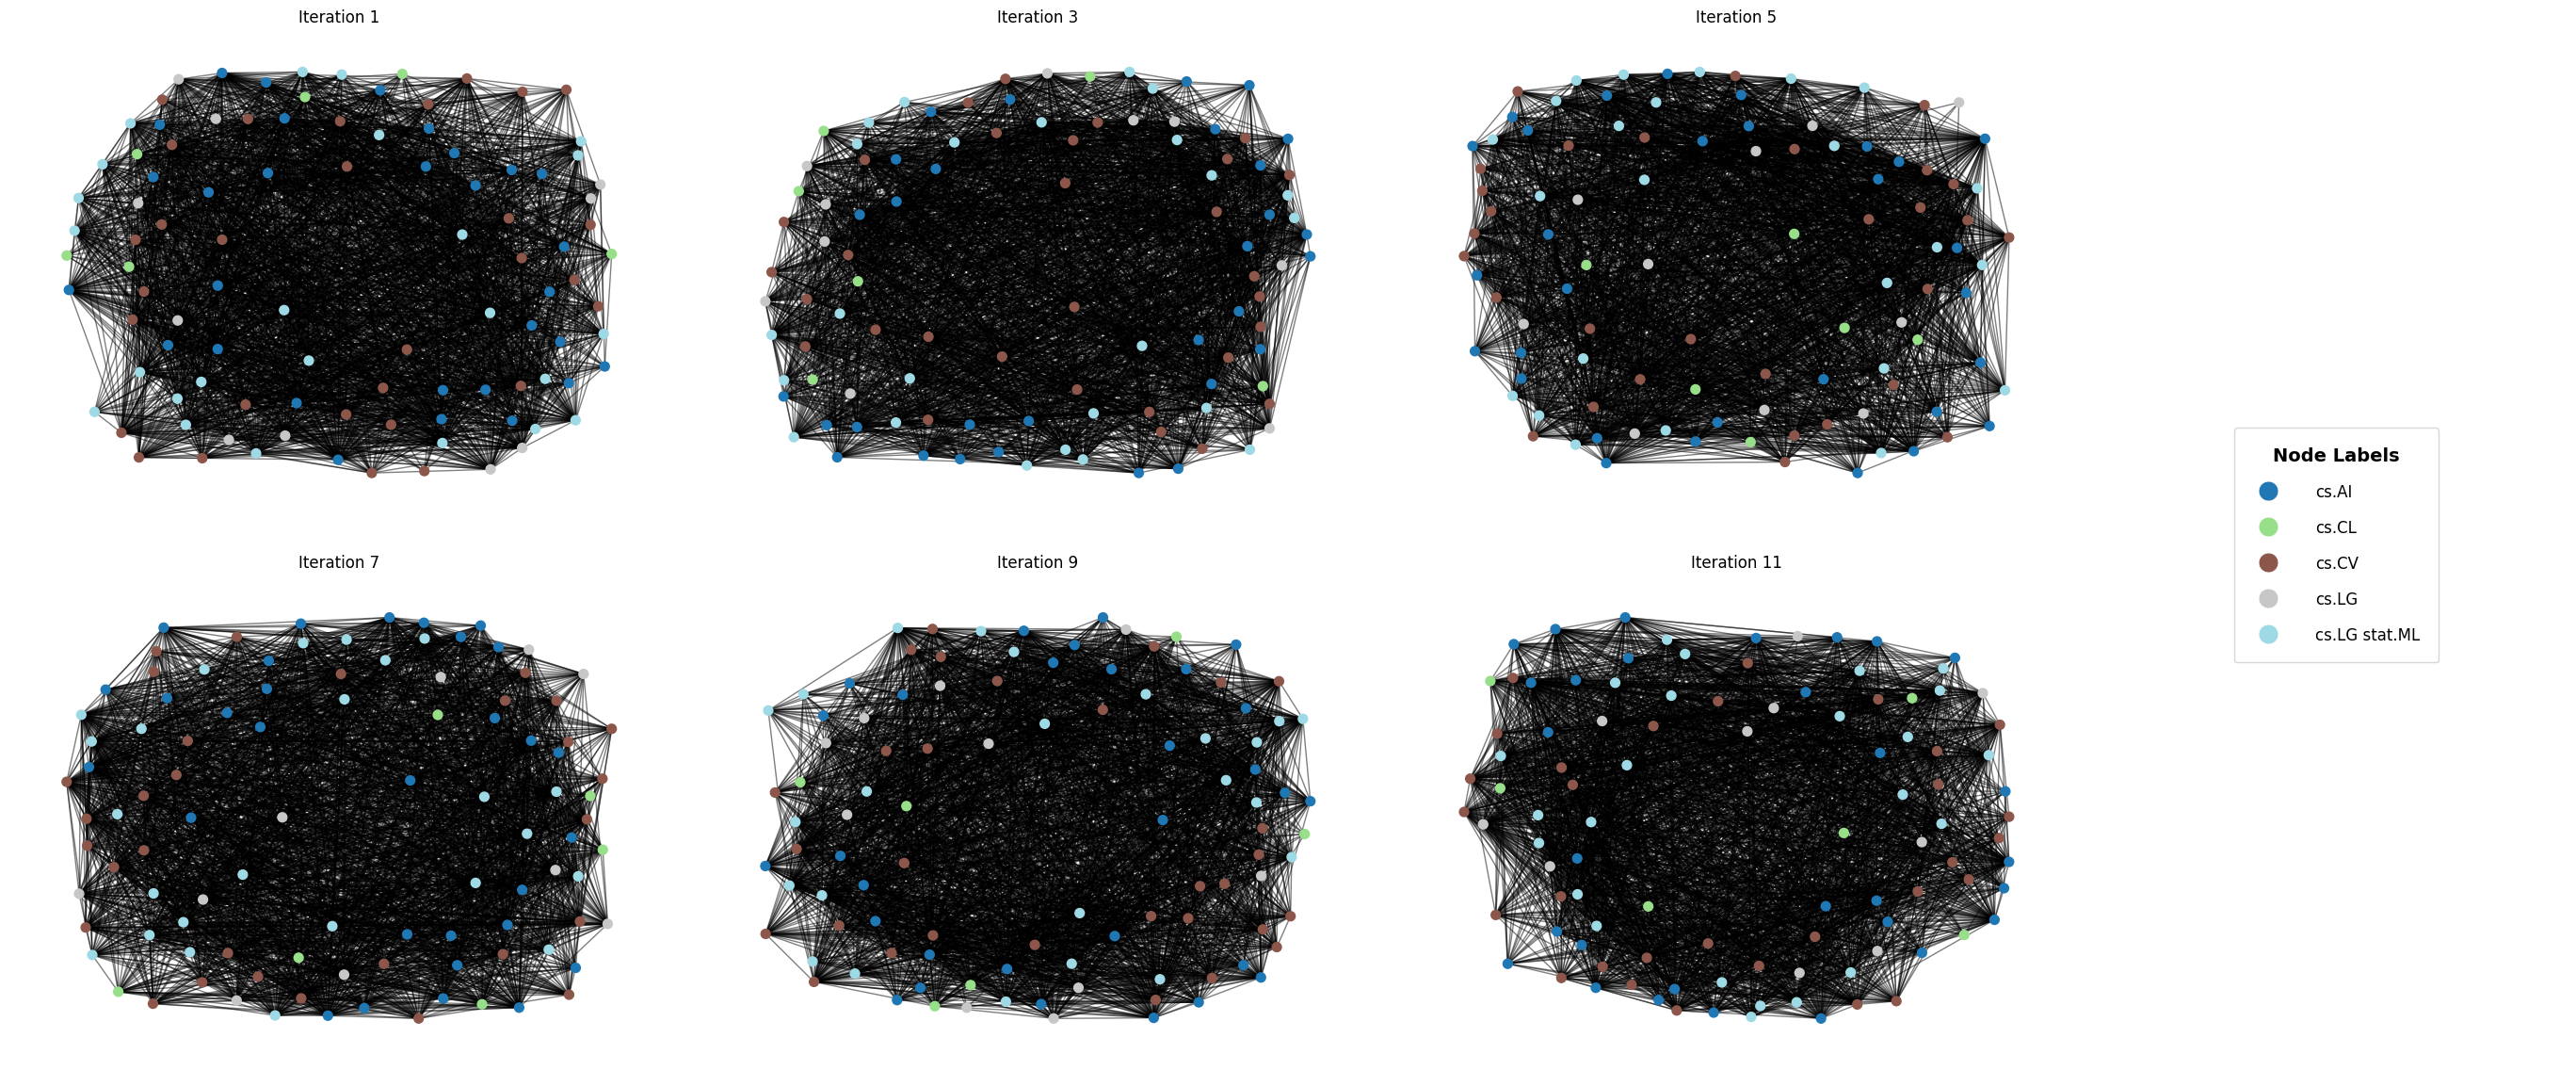

In [47]:
G_after_iter_surgery = my_cluster_iterative_surgery(G)